[*********************100%%**********************]  1 of 1 completed
C:\Users\musab\AppData\Local\Temp\ipykernel_13504\2208017571.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OSTIM_df.drop("Date", axis=1, inplace=True)


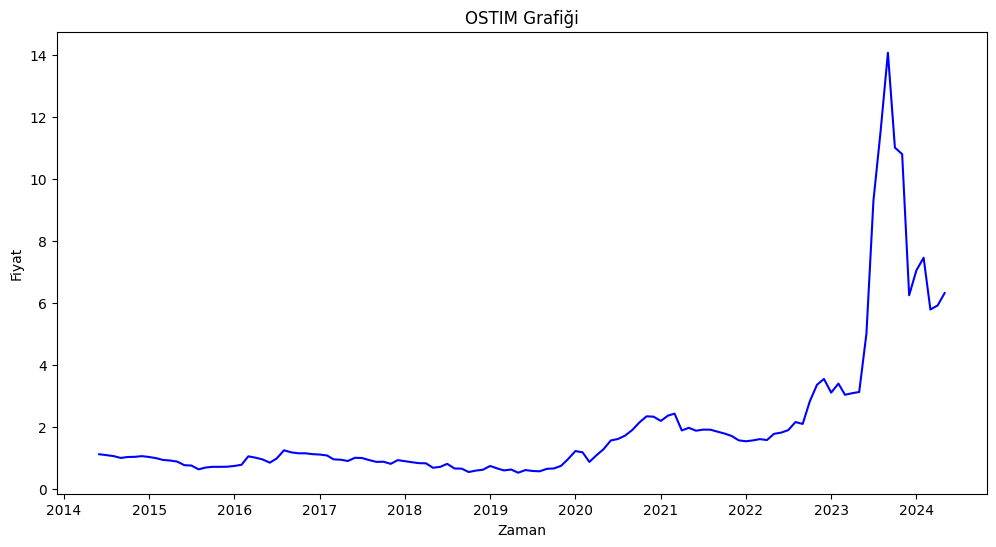

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 20)             440       
                                                                 
 dropout (Dropout)           (None, 1, 20)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                310       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 761
Trainable params: 761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
3/3 [==============================] - ETA: 0

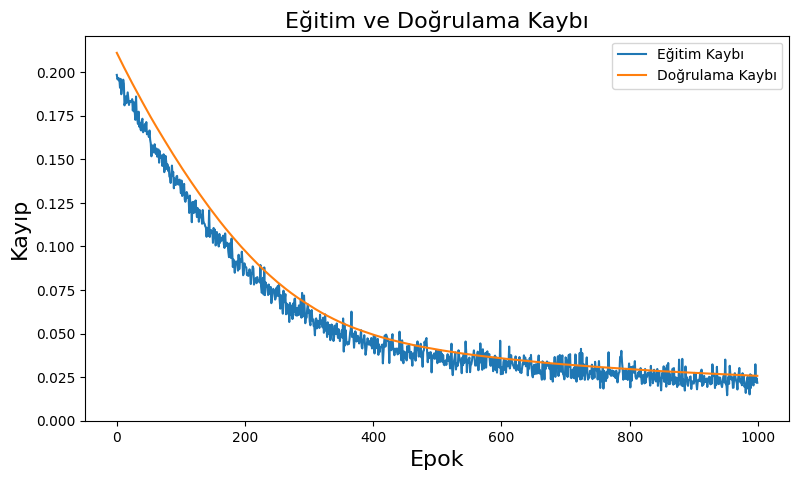

1/1 [==============================] - 0s 45ms/step - loss: 0.0258

Test kaybı: 2.6%
1/1 [==============================] - 0s 30ms/step


C:\Users\musab\AppData\Local\Temp\ipykernel_13504\2208017571.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prediction_df["Tahmin Edilen"] = train_predict
C:\Users\musab\AppData\Local\Temp\ipykernel_13504\2208017571.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prediction_df["Tahmin Edilen"] = test_predict


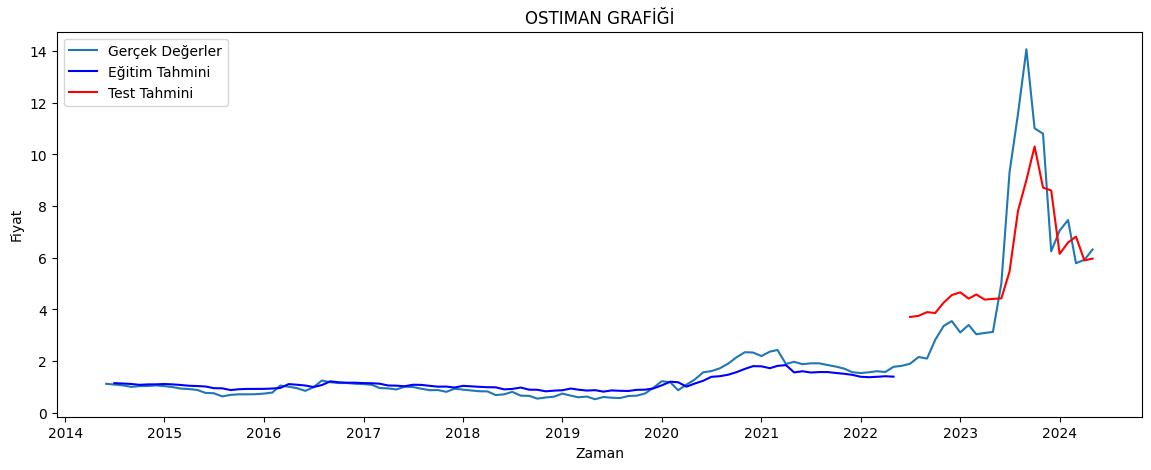

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Veriyi indirme ve inceleme
ticker_symbol = 'OSTIM.IS'
start_date = '2022-05-10'
end_date = '2024-04-10'
df = yf.download(ticker_symbol, period="10y", interval="1mo")
df['Date'] = pd.to_datetime(df.index)

# Veri hazırlama
df["Date"] = pd.to_datetime(df["Date"])
OSTIM_df = df[["Date", "Close"]]
OSTIM_df.index = OSTIM_df["Date"]
OSTIM_df.drop("Date", axis=1, inplace=True)
result_df = OSTIM_df.copy()
plt.figure(figsize=(12,6))
plt.plot(OSTIM_df['Close'], color='blue')
plt.ylabel('Fiyat')
plt.title('OSTIM Grafiği')
plt.xlabel('Zaman')
plt.show()

# Veri önişleme
OSTIM_df = OSTIM_df.values.astype('float32')
def split_data(dataframe, test_size):
    pos = int(round(len(dataframe) * (1 - test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train, test, pos

train, test, pos = split_data(OSTIM_df, 0.20)
scaler_train = MinMaxScaler(feature_range=(0, 1))
train = scaler_train.fit_transform(train)
scaler_test = MinMaxScaler(feature_range=(0, 1))
test = scaler_test.fit_transform(test)

def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

lookback = 1
X_train, Y_train = create_features(train, lookback)
X_test, Y_test = create_features(test, lookback)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

# Model oluşturma
model = Sequential([
    SimpleRNN(units=20, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], lookback)),
    Dropout(0.1),
    SimpleRNN(units=10, activation='relu'),
    Dropout(0.1),
    Dense(1)
])


model.summary()

# Optimizasyon
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Callback'ler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode="min"),
    ModelCheckpoint(filepath='OSTIM.h5', monitor='val_loss', mode='min',
                    save_best_only=True, save_weights_only=False, verbose=1)
]

# Model eğitimi
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=callbacks,
    shuffle=False
)

# Eğitim ve doğrulama kaybını görselleştirme
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.xlabel('Epok', fontsize=16)
plt.ylabel('Kayıp', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Eğitim ve Doğrulama Kaybı', fontsize=16)
plt.show()

# Model değerlendirme
loss = model.evaluate(X_test, Y_test, batch_size=32)
print("\nTest kaybı: %.1f%%" % (100.0 * loss))
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)
Y_train = scaler_train.inverse_transform(Y_train)
Y_test = scaler_test.inverse_transform(Y_test)


# Tahminleri görselleştirme
train_prediction_df = result_df[lookback:pos]
train_prediction_df["Tahmin Edilen"] = train_predict
test_prediction_df = result_df[pos+lookback:]
test_prediction_df["Tahmin Edilen"] = test_predict

plt.figure(figsize=(14,5))
plt.plot(result_df, label='Gerçek Değerler')
plt.plot(train_prediction_df["Tahmin Edilen"], color='blue', label='Eğitim Tahmini')
plt.plot(test_prediction_df["Tahmin Edilen"], color="red", label='Test Tahmini')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.title('OSTIMAN GRAFİĞİ')
plt.legend()
plt.show()

In [2]:
#MAE hesaplama
train_mae = mean_absolute_error(Y_train, train_predict)
test_mae = mean_absolute_error(Y_test, test_predict)
print(f"Eğitim MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

#MAPE hesaplama
train_mape = mean_absolute_percentage_error(Y_train, train_predict) * 100
test_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
print(f"Eğitim MAPE: {train_mape}%")
print(f"Test MAPE: {test_mape}%")

#RMSE hesaplama
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
print(f"Eğitim RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Eğitim MAE: 0.20064128935337067
Test MAE: 1.581221580505371
Eğitim MAPE: 19.833506643772125%
Test MAPE: 34.45305824279785%
Eğitim RMSE: 0.2433050125837326
Test RMSE: 1.9663987159729004
